In [63]:
import pandas as pd
import os
import chardet
import unicodedata
import datetime

from sklearn.neighbors import NearestCentroid

import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
def basic_df_load_and_clean(data_folder, data_file_name, sep = None):
    #this 2 lines allow to retrieve the encoding so that we can open the file
    with open(os.path.join(data_folder, data_file_name), 'rb') as f:
        result = chardet.detect(f.read())

    df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=sep,encoding=result['encoding'])

    # define a helper function to remove accents from text
    def remove_accents(text):
        return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    #setting all column names into lowercase without accents
    # get the current column names
    old_column_names = df.columns.tolist()

    # remove accents and set to lowercase for each column name
    new_column_names = [remove_accents(name).lower() for name in old_column_names]

    # use the new column names to rename the columns
    df = df.rename(columns=dict(zip(old_column_names, new_column_names)))

    # drop rows that have all Nans
    df = df.dropna(how="all")

    return df

def parse_hour(input):
    if "HO" in input:
        out = input.replace("HO","")
    if "H" in input:
        out = input.replace("H","")
    out = int(out)
    if out == 24:
        out = 0
    return out
def complete_weather_dataframe(folder):
    # getting all filenames
    filenames = [filename for filename in os.listdir(folder)]
    filenames = list(filter(lambda filename: filename != ".DS_Store",
                            filenames))

    # definitive dataframe
    definitive_weather_df = pd.DataFrame()

    #loop through all files
    for filename in filenames:
        # load dataframe
        path = os.path.join(folder, filename)
        df = pd.read_csv(path, sep=";")

        #concatenate it to the definitive dataframe
        definitive_weather_df = pd.concat([definitive_weather_df, df])
    
    return definitive_weather_df

In [65]:
data_folder = "../storage/raw"
general_weather_file = "general_info/Estaciones_control_datos_meteorologicos.csv"

hist_weater_file = "historical_data/may_meteo21.csv"
hist_bike_stations = "historical_data/stations_data/202105_merged_trips_stations.csv"

# Finding merging mechanism

## Loading data

In [66]:
ws_df = basic_df_load_and_clean(data_folder, general_weather_file, sep = ";")
hist_stations_df = basic_df_load_and_clean(data_folder, hist_bike_stations)
hist_weather_folder = os.path.join(data_folder, 
                                   "historical_data/weather_data")
weather_df = complete_weather_dataframe(hist_weather_folder)

/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_82282/263655387.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=sep,encoding=result['encoding'])


In [67]:
hist_stations_df

,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,time,year,month,day,hour,plugs_count,unplugs_count
0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196411,1.0,0.0,2.0,0.0,13.0,24.0,7.0,265,-3.729970,40.438960,2021-05-31 23:00:00,2021,5,31,23,0.0,1.0
196412,1.0,0.0,0.0,0.0,0.0,24.0,23.0,266,-3.726990,40.443750,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0
196413,1.0,0.0,0.0,0.0,1.0,24.0,21.0,267,-3.726930,40.443420,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0
196414,1.0,0.0,0.0,0.0,3.0,24.0,20.0,268,-3.727310,40.449120,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0


From historical bike stations information we will want a subset of the dataframe with only 1 row per station, and only the columns id, longitude and magnitude so that we can relate bike stations with weather stations

In [68]:
bs_df = hist_stations_df.groupby("id_station").first().reset_index()[["id_station", "longitude", "latitude"]]
bs_df.columns = ["id_station", "longitud", "latitud"]
bs_df

,id_station,longitud,latitud
0,1,-3.701834,40.417214
1,2,-3.701603,40.417313
2,3,-3.705842,40.420589
3,4,-3.706917,40.430294
4,5,-3.702587,40.428552
...,...,...,...
259,266,-3.726990,40.443750
260,267,-3.726930,40.443420
261,268,-3.727310,40.449120
262,269,-3.729370,40.451090


In [69]:
ws_df.head()

,codigo,codigo_corto,estacion,direccion,longitud_etrs89,latitud_etrs89,altitud,vv (81),dv (82),t (83),...,cod_via,via_clase,via_par,via_nombre,num_via,coordenada_x_etrs89,coordenada_y_etrs89,longitud,latitud,unnamed: 23
0,28079004.0,4.0,Plaza España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637.0,NaN,NaN,X,...,273600.0,PLAZA,DE,ESPAÑA,NaN,"439579,3291","4475049,263",-3.712257,40.423882,NaN
1,28079008.0,8.0,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3°40'56.22""O","40°25'17.63""N",672.0,NaN,NaN,X,...,18900.0,CALLE,DE,ALCALA,NaN,"442117,2366","4474770,696",-3.682316,40.421553,NaN
2,28079016.0,16.0,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695.0,NaN,NaN,X,...,798700.0,CALLE,DEL,VIZCONDE DE LOS ASILOS,NaN,"445786,1729","4476796,019",-3.639242,40.440046,NaN
3,28079018.0,18.0,Farolillo,Calle Farolillo - C/Ervigio,"3°43'54.61""O","40°23'41.22""N",632.0,NaN,NaN,X,...,1903.0,CALLE,DEL,FAROLILLO,NaN,"437891,6961","4471832,769",-3.731836,40.394782,NaN
4,28079024.0,24.0,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",646.0,X,X,X,...,905219.0,CARRETERA,DEL,TELEFERICO,NaN,"436598,5637","4474571,618",-3.747345,40.419358,NaN


In [70]:
ws_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo               26 non-null     float64
 1   codigo_corto         26 non-null     float64
 2   estacion             26 non-null     object 
 3   direccion            26 non-null     object 
 4   longitud_etrs89      26 non-null     object 
 5   latitud_etrs89       26 non-null     object 
 6   altitud              26 non-null     float64
 7   vv (81)              10 non-null     object 
 8   dv (82)              10 non-null     object 
 9   t (83)               25 non-null     object 
 10  hr (86)              23 non-null     object 
 11  pb (87)              8 non-null      object 
 12  rs (88)              8 non-null      object 
 13  p (89)               10 non-null     object 
 14  cod_via              25 non-null     float64
 15  via_clase            26 non-null     objec

The nulls in each magnitude mark the stations that **do not** register that magnitude

In [71]:
bs_df.head()

,id_station,longitud,latitud
0,1,-3.701834,40.417214
1,2,-3.701603,40.417313
2,3,-3.705842,40.420589
3,4,-3.706917,40.430294
4,5,-3.702587,40.428552


In [72]:
bs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_station  264 non-null    int64  
 1   longitud    264 non-null    float64
 2   latitud     264 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.3 KB


## Fixing problems in the general list of weather stations

### Some stations, for some magnitudes, did not have the whole month of data

This is a problem, because as we are dealing with time series, we need the data to be continuous. We cannot miss a day. From the analysis we have seen that it is a whole station which presents this problem. It makes sense, as it would be very strange for a station to register some magnitudes and not others in one period of time. To solve for this, we will delete the registers of the stations that don't account for the maximum number of days registering data on that month. We need to set it like that because each month has 30, 31 or 27 days. Then, as we have a lot of weather stations, we will assign the bike stations close to the deleted weather station to another weather station

Thankfully this problem cannot happen in the hours time range, as a day data point contains the 24 hours.

### The weather stations file IS NOT CORRECT FOR THE MAGNITUDES EACH STATION MEASURES

For example, for station 16 the csv states that it is measuring magnitudes 83 and 86, but then only magnitude 86 is registered for march of 2021. Again, we don't know the reason for this misconfiguration, so we will make the code robust adjusting the magnitudes stated in the ws_df to those seen in the historical dataframe.

Update: we have seen that if we try to apply the process to the whole weather datasets (all years and months), depending on the month, some stations are active and some arent. Also, some dont have all the days of the month registered. So to create the dataframe relating bike stations and weather stations, we will create first a weather stations with the columns (year, month, station, magnitude) from the historical data with all stations per month per year and per magnitude that are registering the whole month. We will use then the information df to add lattitude and longitude to this df.

In [73]:
df_stations_registers = weather_df[["ESTACION","MAGNITUD","ANO","MES", "DIA"]].groupby(["ESTACION","MAGNITUD","ANO","MES"]).count().reset_index()
df_stations_registers["time"] =df_stations_registers.apply(lambda row: datetime.datetime(row["ANO"], row["MES"],1), axis = 1)
df_stations_registers

,ESTACION,MAGNITUD,ANO,MES,DIA,time
0,4,83,2019,1,31,2019-01-01
1,4,83,2019,2,28,2019-02-01
2,4,83,2019,3,31,2019-03-01
3,4,83,2019,4,30,2019-04-01
4,4,83,2019,5,31,2019-05-01
...,...,...,...,...,...,...
4535,115,86,2022,9,2,2022-09-01
4536,115,86,2023,1,31,2023-01-01
4537,115,86,2023,2,28,2023-02-01
4538,115,86,2023,3,26,2023-03-01


<AxesSubplot: xlabel='time', ylabel='DIA'>

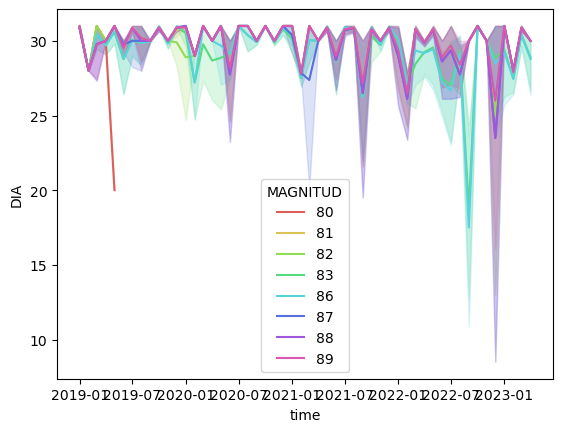

In [74]:
my_palette = sns.color_palette("hls", n_colors=len(list(df_stations_registers["MAGNITUD"].unique())))

sns.lineplot(data=df_stations_registers, x="time", y="DIA", hue = "MAGNITUD", palette=my_palette)

In [75]:
# filtering months
# Groups: 1-31 days, 0-30 days, 3-28 or 29 days

days_per_month = {
    1:31,
    2:28,
    3:31,
    4:30,
    5:31,
    6:30,
    7:31,
    8:31,
    9:30,
    10:31,
    11:30,
    12:31
}

df_stations_registers["month_days"] = df_stations_registers.apply(lambda row: days_per_month[row["MES"]], axis = 1)
df_stations_registers

,ESTACION,MAGNITUD,ANO,MES,DIA,time,month_days
0,4,83,2019,1,31,2019-01-01,31
1,4,83,2019,2,28,2019-02-01,28
2,4,83,2019,3,31,2019-03-01,31
3,4,83,2019,4,30,2019-04-01,30
4,4,83,2019,5,31,2019-05-01,31
...,...,...,...,...,...,...,...
4535,115,86,2022,9,2,2022-09-01,30
4536,115,86,2023,1,31,2023-01-01,31
4537,115,86,2023,2,28,2023-02-01,28
4538,115,86,2023,3,26,2023-03-01,31


In [76]:
df_stations_registers_filtered = df_stations_registers[df_stations_registers["month_days"] <= df_stations_registers["DIA"]]

<AxesSubplot: xlabel='time', ylabel='DIA'>

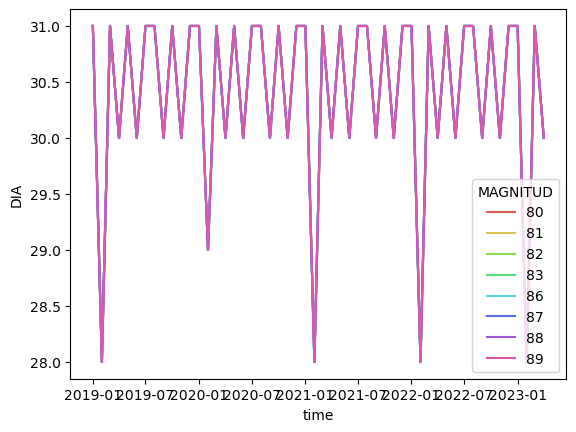

In [77]:
my_palette = sns.color_palette("hls", n_colors=len(list(df_stations_registers["MAGNITUD"].unique())))

sns.lineplot(data=df_stations_registers_filtered, x="time", y="DIA", hue = "MAGNITUD", palette=my_palette)

In [78]:
df_stations_registers_filtered[(df_stations_registers_filtered["ESTACION"] == 35) & (df_stations_registers_filtered["ANO"] == 2019)]

,ESTACION,MAGNITUD,ANO,MES,DIA,time,month_days
635,35,83,2019,1,31,2019-01-01,31
636,35,83,2019,2,28,2019-02-01,28
638,35,83,2019,4,30,2019-04-01,30
639,35,83,2019,5,31,2019-05-01,31
640,35,83,2019,6,30,2019-06-01,30
641,35,83,2019,7,31,2019-07-01,31
642,35,83,2019,8,31,2019-08-01,31
643,35,83,2019,9,30,2019-09-01,30
644,35,83,2019,10,31,2019-10-01,31
645,35,83,2019,11,30,2019-11-01,30


In [79]:
df_stations_registers_filtered = df_stations_registers_filtered[["ESTACION", "MAGNITUD", "ANO", "MES"]]
weather_df_filtered = pd.merge(df_stations_registers_filtered,weather_df, on=["ESTACION", "MAGNITUD", "ANO", "MES"], how="left")

In [80]:
weather_df_filtered.head()

,ESTACION,MAGNITUD,ANO,MES,PROVINCIA,MUNICIPIO,PUNTO_MUESTREO,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,4,83,2019,1,28,79,28079004_83_98,1,1.1,V,...,8.6,V,6.0,V,3.7,V,2.3,V,1.0,V
1,4,83,2019,1,28,79,28079004_83_98,2,0.7,V,...,8.3,V,4.9,V,3.6,V,2.6,V,0.6,V
2,4,83,2019,1,28,79,28079004_83_98,3,0.0,V,...,8.0,V,5.4,V,3.6,V,2.6,V,1.5,V
3,4,83,2019,1,28,79,28079004_83_98,4,0.7,V,...,8.5,V,5.6,V,2.8,V,2.1,V,0.6,V
4,4,83,2019,1,28,79,28079004_83_98,5,-0.1,V,...,8.3,V,5.2,V,3.2,V,2.1,V,0.8,V


In [83]:
# we add the latitude and longitude to all weather stations in ws_df_filtered
ws_df_filtered=pd.merge(df_stations_registers_filtered, ws_df[["codigo_corto","longitud", "latitud"]], left_on="ESTACION", right_on="codigo_corto")

In [84]:
ws_df_filtered.head()

,ESTACION,MAGNITUD,ANO,MES,codigo_corto,longitud,latitud
0,4,83,2019,1,4.0,-3.712257,40.423882
1,4,83,2019,2,4.0,-3.712257,40.423882
2,4,83,2019,3,4.0,-3.712257,40.423882
3,4,83,2019,4,4.0,-3.712257,40.423882
4,4,83,2019,5,4.0,-3.712257,40.423882


## Merging mechanism

To merge bike stations and weather stations we are going to use the location. We are going to assign the closest weather station to each bike station, so that weather data is as accurate as possible. We are going to use NearestCentroid, which bassically assigns the closest class to each data point. As this classification is a spatial classification taking into account longitude and latitude, it will be more than enough

IMPORTANT! I have seen that not all stations measure all magnitudes. So the ideal case scenario is to build a merging mechanism for each magnitude, so that each bike station looks for the data of each magnitude in the nearest weather station that measures that magnitude.

### Merging mechanism per each magnitude

In [85]:
"""
81 - VELOCIDAD VIENTO
82 - DIR. DE VIENTO
83 - TEMPERATURA
86 - HUMEDAD RELATIVA
87 - PRESION BARIOMETRICA
88 - RADIACION SOLAR
89 - PRECIPITACIÓN"""
MAGNITUDES = [81, 82, 83, 86, 87, 88, 89]

### Assigning weather station to bike stations for each magnitude

In [87]:
# adding for each magnitude the nearest weather station to each bike station per year per month
classifier = NearestCentroid()

bs_df = bs_df.sort_values("id_station")
# we have a df of per each month of each year and each mangitude, which stations register the whole month.
# lets assign to those stations the nearest bike station at each moment in time.
coord_bs = bs_df[["latitud", "longitud"]]
relate_ws_bs = pd.DataFrame(columns=["bike_station","longitud","latitud", "ANO", "MES","MAGNITUD", "weather_station"])
i = 0
for year in range(2019,2024):
    for month in range(1,13):

        if year == 2023 and month > 4:
            break
        
        for magnitude in MAGNITUDES:
            i +=1
            #we select the rows of the stations of that month
            ws_df_magnitude = ws_df_filtered[(ws_df_filtered["ANO"] == year) & 
                                             (ws_df_filtered["MES"] == month) & 
                                             (ws_df_filtered["MAGNITUD"] == magnitude)]
            
            #we get the coordinates of the stations that measure that specific magnitude
            coord_ws_magnitude = ws_df_magnitude[["latitud","longitud"]]
        
            stations_magnitude = ws_df_magnitude["ESTACION"]
           
            # we fit the model with the stations of this magnitude
            classifier.fit(coord_ws_magnitude, stations_magnitude)
            # we assign a weather station to each bike station per each magnitude in that moment of time
            ws_for_bs_magnitude = classifier.predict(coord_bs)
            
            bs_df["ESTACION"] = ws_for_bs_magnitude

            # we get the bike station in the weather dataframe. CAREFUL! not all weather stations
            # will have a bike stations BUT all bike stations will have a weather station
            merg = pd.merge(ws_df_magnitude[["ANO", "MES","MAGNITUD", "ESTACION"]],bs_df, on="ESTACION", how="left")
            # we filter through the weather stations that HAVE a bike station
            merg = merg.loc[~merg["id_station"].isna(), ["id_station","longitud","latitud", "ANO", "MES","MAGNITUD", "ESTACION"]]
            
            merg.columns = ["bike_station","longitud","latitud", "ANO", "MES","MAGNITUD", "weather_station"]
            # we put all the information into a final dataframe
            relate_ws_bs = pd.concat([relate_ws_bs, merg])


In [88]:
relate_ws_bs = relate_ws_bs.pivot(index=['ANO', 'MES', 'bike_station',"longitud","latitud"], columns='MAGNITUD', values='weather_station').reset_index()
relate_ws_bs.columns = ['ANO', 'MES', 'bike_station',"longitud","latitud", 'weather_station_81', 'weather_station_82', 
                  'weather_station_83', 'weather_station_86', 'weather_station_87', 'weather_station_88',
                  'weather_station_89']
relate_ws_bs.head()

/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_82282/2118942162.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  relate_ws_bs = relate_ws_bs.pivot(index=['ANO', 'MES', 'bike_station',"longitud","latitud"], columns='MAGNITUD', values='weather_station').reset_index()


,ANO,MES,bike_station,longitud,latitud,weather_station_81,weather_station_82,weather_station_83,weather_station_86,weather_station_87,weather_station_88,weather_station_89
0,2019,1,1.0,-3.701834,40.417214,56,56,35,35,56,24,56
1,2019,1,2.0,-3.701603,40.417313,56,56,35,35,56,24,56
2,2019,1,3.0,-3.705842,40.420589,56,56,35,35,56,24,56
3,2019,1,4.0,-3.706917,40.430294,24,24,4,109,24,24,24
4,2019,1,5.0,-3.702587,40.428552,24,24,109,109,24,24,24


now we have one weather station per magnitude assigned to each bike station at each moment in time so that we have the most accurate prediction of each weather magnitude possible. Also, we are taking into account only the weather stations that are gathering data.

### Visualizing weather stations

In [89]:
ws_df_filtered_plot = ws_df_filtered.groupby("codigo_corto").first().reset_index()


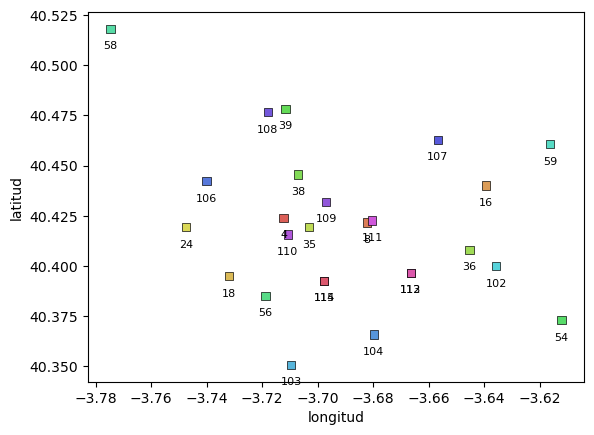

In [90]:
# palette creation with respect to the weather stations that are used for each magnitude
weather_station_codes = ws_df_filtered_plot["codigo_corto"]
my_palette = sns.color_palette("hls", n_colors=len(list(weather_station_codes)))

# scatter plot of the weather stations
ax = sns.scatterplot(data=ws_df_filtered_plot, x="longitud", y="latitud",hue = ws_df_filtered_plot["codigo_corto"], palette=my_palette,
                marker="s", edgecolor="black", alpha=1, legend=None)

for i in range(ws_df_filtered_plot.shape[0]):
        ax.text(ws_df_filtered_plot.iloc[i]["longitud"], ws_df_filtered_plot.iloc[i]["latitud"]-0.01, int(ws_df_filtered_plot.iloc[i]["codigo_corto"]), ha="center", fontsize=8)

### Visualizing assignation of weather stations

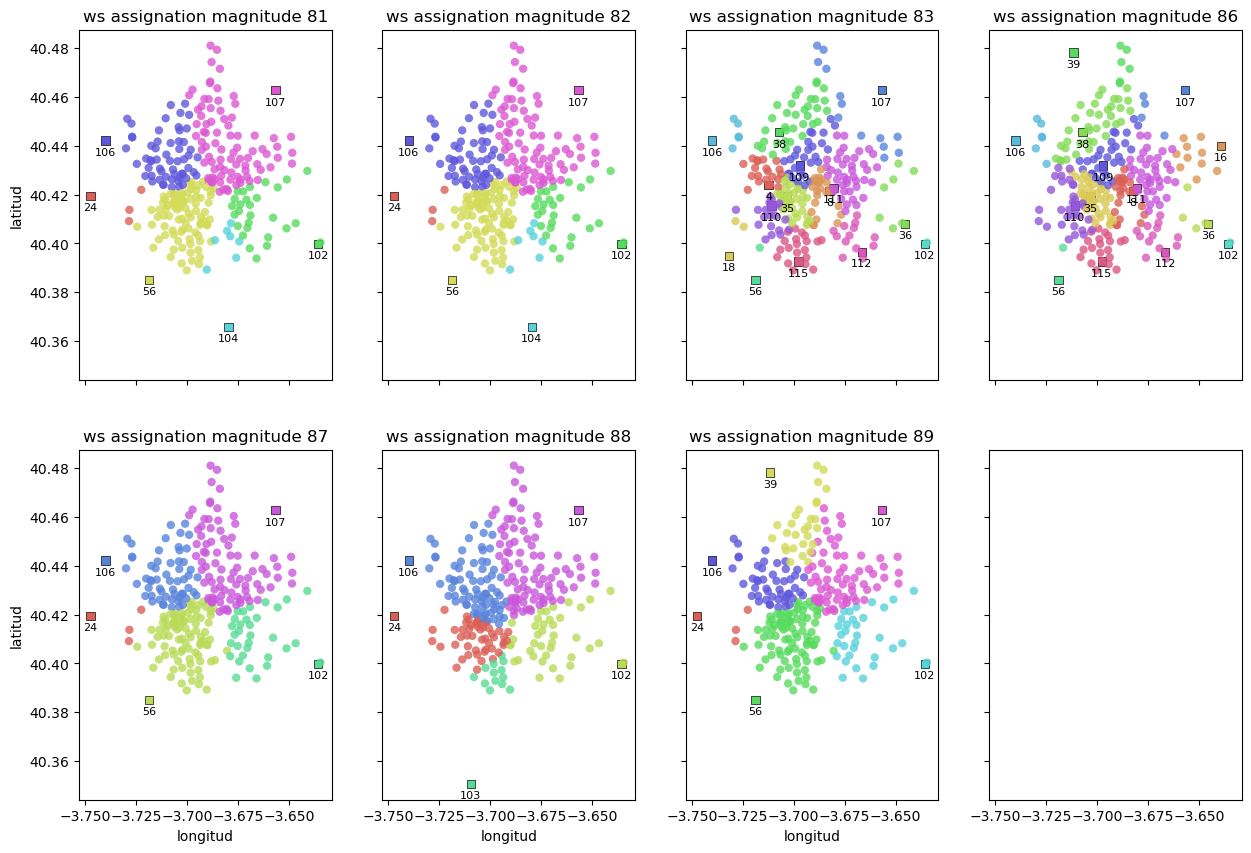

In [91]:
nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10),sharex=True, sharey=True)

relate_ws_bs_plot = relate_ws_bs[(relate_ws_bs["ANO"] == 2021) & (relate_ws_bs["MES"] == 5)]

for index, magnitude in enumerate(MAGNITUDES):
    # this is to build the rows and columns of the subplot
    if index < ncols:
        row = 0
        col = index
    else:
        row = 1
        col = index - ncols

    # palette creation with respect to the weather stations that are used for each magnitude
    weather_station_codes = relate_ws_bs_plot["weather_station_" + str(magnitude)].unique()
    my_palette = sns.color_palette("hls", n_colors=len(list(weather_station_codes)))

    # subsample of the weather stations that register this specific magnitude
    ws_df_aux = ws_df_filtered.loc[(ws_df_filtered["codigo_corto"].isin(relate_ws_bs_plot["weather_station_" + str(magnitude)])) &
                                   (ws_df_filtered["ANO"] == 2021) & (ws_df_filtered["MES"] == 5),["longitud", "latitud", "codigo_corto"]]
    # scatter plot of the weather stations
    ws_df_aux = ws_df_aux.groupby("codigo_corto").first().reset_index()
    sns.scatterplot(data=ws_df_aux, x="longitud", y="latitud",hue = ws_df_aux["codigo_corto"], palette=my_palette,
                    marker="s", edgecolor="black", alpha=1, legend=None, ax=axes[row, col])
    
    # inserting labels to weather stations to know the code of each one
    for i in range(ws_df_aux.shape[0]):
        axes[row, col].text(ws_df_aux.iloc[i]["longitud"], 
                            ws_df_aux.iloc[i]["latitud"]-0.006, 
                            int(ws_df_aux.iloc[i]["codigo_corto"]), 
                            ha="center", fontsize=8)

    # subsample of the bike stations to get the weather station codes assigned for this magnitude
    bs_df_aux = relate_ws_bs_plot[["longitud", "latitud", "weather_station_" + str(magnitude)]]
    # scatter plot of the bike stations
    sns.scatterplot(data=bs_df_aux, x="longitud", y="latitud",hue = bs_df_aux["weather_station_" + str(magnitude)],palette= my_palette,
                    marker="o", edgecolor="none", alpha=0.8, legend=None, ax=axes[row, col])
    
    # settint titles to the subplots
    axes[row,col].set(title="ws assignation magnitude " + str(magnitude))


This plot represents for each magnitude which is the weather station assigned to each bike station. FOR MAY 2021.

Weather stations are squares, bike stations circles, and all bike stations assigned to a weather station share color with the weather station.

# Processing weather data

In [92]:
weather_df_filtered.head()

,ESTACION,MAGNITUD,ANO,MES,PROVINCIA,MUNICIPIO,PUNTO_MUESTREO,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,4,83,2019,1,28,79,28079004_83_98,1,1.1,V,...,8.6,V,6.0,V,3.7,V,2.3,V,1.0,V
1,4,83,2019,1,28,79,28079004_83_98,2,0.7,V,...,8.3,V,4.9,V,3.6,V,2.6,V,0.6,V
2,4,83,2019,1,28,79,28079004_83_98,3,0.0,V,...,8.0,V,5.4,V,3.6,V,2.6,V,1.5,V
3,4,83,2019,1,28,79,28079004_83_98,4,0.7,V,...,8.5,V,5.6,V,2.8,V,2.1,V,0.6,V
4,4,83,2019,1,28,79,28079004_83_98,5,-0.1,V,...,8.3,V,5.2,V,3.2,V,2.1,V,0.8,V


In [93]:
weather_df_filtered.groupby(["ESTACION", "MAGNITUD", "ANO", "MES"]).count()["DIA"].unique()

array([31, 28, 30, 29])

In [94]:
melted_df = pd.melt(weather_df_filtered, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA'],
                        value_vars=['H{:02d}'.format(hour) for hour in range(1, 25)],
                        var_name='HORA', value_name='CANTIDAD')

melted_df

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,4,83,28079004_83_98,2019,1,1,H01,1.1
1,4,83,28079004_83_98,2019,1,2,H01,0.7
2,4,83,28079004_83_98,2019,1,3,H01,0.0
3,4,83,28079004_83_98,2019,1,4,H01,0.7
4,4,83,28079004_83_98,2019,1,5,H01,-0.1
...,...,...,...,...,...,...,...,...
2972275,115,86,28079115_86_98,2023,4,26,H24,24.0
2972276,115,86,28079115_86_98,2023,4,27,H24,32.0
2972277,115,86,28079115_86_98,2023,4,28,H24,30.0
2972278,115,86,28079115_86_98,2023,4,29,H24,37.0


In [99]:
relate_ws_bs.head()

,ANO,MES,bike_station,longitud,latitud,weather_station_81,weather_station_82,weather_station_83,weather_station_86,weather_station_87,weather_station_88,weather_station_89
0,2019,1,1.0,-3.701834,40.417214,56,56,35,35,56,24,56
1,2019,1,2.0,-3.701603,40.417313,56,56,35,35,56,24,56
2,2019,1,3.0,-3.705842,40.420589,56,56,35,35,56,24,56
3,2019,1,4.0,-3.706917,40.430294,24,24,4,109,24,24,24
4,2019,1,5.0,-3.702587,40.428552,24,24,109,109,24,24,24


In [115]:
magnitude = 81
bs_df_column = "weather_station_" + str(magnitude)
bs_df_column

'weather_station_81'

In [116]:
# we get the assigned weather stations for each magnitude (we don't need the rest)
magnitude_stations = relate_ws_bs.loc[(relate_ws_bs["ANO"]==2021) & (relate_ws_bs["MES"]==5),bs_df_column].unique()
magnitude_stations

array([56, 106, 102, 104, 107, 24], dtype=object)

In [117]:
# we filter historical weather station data with the assigned codes
hist_weather_magnitude_stations = melted_df[(melted_df["ANO"]==2021) &
                                             (melted_df["MES"]==5)&
                                             (melted_df["MAGNITUD"]==magnitude)&
                                             (melted_df["ESTACION"].isin(magnitude_stations))]
hist_weather_magnitude_stations

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
8413,24,81,28079024_81_98,2021,5,1,H01,0.55
8414,24,81,28079024_81_98,2021,5,2,H01,0.76
8415,24,81,28079024_81_98,2021,5,3,H01,1.44
8416,24,81,28079024_81_98,2021,5,4,H01,1.22
8417,24,81,28079024_81_98,2021,5,5,H01,0.71
...,...,...,...,...,...,...,...,...
2940902,107,81,28079107_81_98,2021,5,27,H24,1.98
2940903,107,81,28079107_81_98,2021,5,28,H24,1.48
2940904,107,81,28079107_81_98,2021,5,29,H24,0.37
2940905,107,81,28079107_81_98,2021,5,30,H24,1.87


In [118]:
6*31*24

4464

In [119]:
# we subset the bike stations information df so that we only merge the current magnitude to the hist weather df
bs_df_magnitude = relate_ws_bs.loc[(relate_ws_bs["ANO"]==2021) & (relate_ws_bs["MES"]==5),["bike_station", bs_df_column]]
bs_df_magnitude

,bike_station,weather_station_81
7392,1.0,56
7393,2.0,56
7394,3.0,56
7395,4.0,106
7396,5.0,106
...,...,...
7651,266.0,106
7652,267.0,106
7653,268.0,106
7654,269.0,106


In [120]:
# we merge the weather station to each bike station for each moment in time and for each magnitude, as depending
# on this information each bike station will get the information from one weather station or another
aux = bs_df_magnitude.merge(hist_weather_magnitude_stations, how = "left", right_on= ["ESTACION"], left_on=bs_df_column)
aux = aux.drop(bs_df_column, axis = 1)
aux

,bike_station,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,1.0,56,81,28079056_81_98,2021,5,1,H01,0.68
1,1.0,56,81,28079056_81_98,2021,5,2,H01,0.97
2,1.0,56,81,28079056_81_98,2021,5,3,H01,1.00
3,1.0,56,81,28079056_81_98,2021,5,4,H01,1.30
4,1.0,56,81,28079056_81_98,2021,5,5,H01,0.65
...,...,...,...,...,...,...,...,...,...
196411,270.0,107,81,28079107_81_98,2021,5,27,H24,1.98
196412,270.0,107,81,28079107_81_98,2021,5,28,H24,1.48
196413,270.0,107,81,28079107_81_98,2021,5,29,H24,0.37
196414,270.0,107,81,28079107_81_98,2021,5,30,H24,1.87


In [121]:
264*31*24

196416

In [123]:
hist_weather = pd.DataFrame(columns=melted_df.columns)
hist_weather.insert(0, "bike_station", None)
hist_weather = pd.concat([hist_weather, aux])
hist_weather

,bike_station,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,1.0,56,81,28079056_81_98,2021,5,1,H01,0.68
1,1.0,56,81,28079056_81_98,2021,5,2,H01,0.97
2,1.0,56,81,28079056_81_98,2021,5,3,H01,1.00
3,1.0,56,81,28079056_81_98,2021,5,4,H01,1.30
4,1.0,56,81,28079056_81_98,2021,5,5,H01,0.65
...,...,...,...,...,...,...,...,...,...
196411,270.0,107,81,28079107_81_98,2021,5,27,H24,1.98
196412,270.0,107,81,28079107_81_98,2021,5,28,H24,1.48
196413,270.0,107,81,28079107_81_98,2021,5,29,H24,0.37
196414,270.0,107,81,28079107_81_98,2021,5,30,H24,1.87


In [145]:
hist_weather = pd.DataFrame(columns=melted_df.columns)
hist_weather.insert(0, "bike_station", None)


for year in range(2019,2024):

    aux_year = pd.DataFrame(columns=melted_df.columns)
    aux_year.insert(0, "bike_station", None)

    for month in range(1,13):
        print(f"year: {year}, month: {month}")
        if year == 2023 and month > 4:
            break

        aux_month = pd.DataFrame(columns=melted_df.columns)
        aux_month.insert(0, "bike_station", None)
        
        for magnitude in MAGNITUDES:
            bs_df_column = "weather_station_" + str(magnitude)
            # we get the assigned weather stations for each magnitude (we don't need the rest)
            magnitude_stations = relate_ws_bs.loc[(relate_ws_bs["ANO"]==year) & (relate_ws_bs["MES"]==month),bs_df_column].unique()
            # we filter historical weather station data with the assigned codes
            hist_weather_magnitude_stations = melted_df[(melted_df["ANO"]==year) &
                                             (melted_df["MES"]==month)&
                                             (melted_df["MAGNITUD"]==magnitude)&
                                             (melted_df["ESTACION"].isin(magnitude_stations))]
            # we subset the bike stations information df so that we only merge the current magnitude to the hist weather df
            bs_df_magnitude = relate_ws_bs.loc[(relate_ws_bs["ANO"]==year) & (relate_ws_bs["MES"]==month),["bike_station", bs_df_column]]
            
            # we merge the weather station to each bike station for each moment in time and for each magnitude, as depending
            # on this information each bike station will get the information from one weather station or another
            aux = bs_df_magnitude.merge(hist_weather_magnitude_stations, how = "left", right_on= ["ESTACION"], left_on=bs_df_column)
            aux = aux.drop(bs_df_column, axis = 1)
            
            aux_month = pd.concat([aux_month, aux])

        aux_year = pd.concat([aux_year, aux_month])
    
    hist_weather = pd.concat([hist_weather, aux_year])
        
    
hist_weather.head()

year: 2019, month: 1
year: 2019, month: 2
year: 2019, month: 3
year: 2019, month: 4
year: 2019, month: 5
year: 2019, month: 6
year: 2019, month: 7
year: 2019, month: 8
year: 2019, month: 9
year: 2019, month: 10
year: 2019, month: 11
year: 2019, month: 12
year: 2020, month: 1
year: 2020, month: 2
year: 2020, month: 3
year: 2020, month: 4
year: 2020, month: 5
year: 2020, month: 6
year: 2020, month: 7
year: 2020, month: 8
year: 2020, month: 9
year: 2020, month: 10
year: 2020, month: 11
year: 2020, month: 12
year: 2021, month: 1
year: 2021, month: 2
year: 2021, month: 3
year: 2021, month: 4
year: 2021, month: 5
year: 2021, month: 6
year: 2021, month: 7
year: 2021, month: 8
year: 2021, month: 9
year: 2021, month: 10
year: 2021, month: 11
year: 2021, month: 12
year: 2022, month: 1
year: 2022, month: 2
year: 2022, month: 3
year: 2022, month: 4
year: 2022, month: 5
year: 2022, month: 6
year: 2022, month: 7
year: 2022, month: 8
year: 2022, month: 9
year: 2022, month: 10
year: 2022, month: 11
ye

,bike_station,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,1.0,56,81,28079056_81_98,2019,1,1,H01,0.68
1,1.0,56,81,28079056_81_98,2019,1,2,H01,0.83
2,1.0,56,81,28079056_81_98,2019,1,3,H01,0.63
3,1.0,56,81,28079056_81_98,2019,1,4,H01,0.66
4,1.0,56,81,28079056_81_98,2019,1,5,H01,0.71


In [130]:
4*12*30*24*264*7+4*30*24*264*7

69189120

In [147]:
hist_weather = hist_weather.pivot_table(index=['bike_station', 'ANO', 'MES', 'DIA', 'HORA'], columns='MAGNITUD', values='CANTIDAD')
hist_weather

MAGNITUD                          81    82    83    86     87     88   89
bike_station ANO  MES DIA HORA                                           
1.0          2019 1   1   H01   0.68  48.0   6.2  58.0  959.0    1.0  0.0
                          H02   0.69  32.0   6.2  56.0  959.0    1.0  0.0
                          H03   0.70  43.0   4.8  61.0  959.0    1.0  0.0
                          H04   0.70  74.0   4.3  64.0  959.0    1.0  0.0
                          H05   0.66  67.0   4.6  62.0  959.0    1.0  0.0
...                              ...   ...   ...   ...    ...    ...  ...
270.0        2023 4   30  H20   1.78   1.0  23.6  29.0  939.0  161.0  0.0
                          H21   1.75  14.0  22.3  30.0  939.0   53.0  0.0
                          H22   1.72   1.0  21.1  32.0  939.0    2.0  0.0
                          H23   1.85   9.0  19.8  35.0  940.0    1.0  0.0
                          H24   2.07  25.0  18.3  41.0  940.0    1.0  0.0

[10017216 rows x 7 columns]

In [142]:
264*31*24

196416

In [148]:
hist_weather = hist_weather.reset_index()
hist_weather

MAGNITUD,bike_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1.0,2019,1,1,H01,0.68,48.0,6.2,58.0,959.0,1.0,0.0
1,1.0,2019,1,1,H02,0.69,32.0,6.2,56.0,959.0,1.0,0.0
2,1.0,2019,1,1,H03,0.70,43.0,4.8,61.0,959.0,1.0,0.0
3,1.0,2019,1,1,H04,0.70,74.0,4.3,64.0,959.0,1.0,0.0
4,1.0,2019,1,1,H05,0.66,67.0,4.6,62.0,959.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10017211,270.0,2023,4,30,H20,1.78,1.0,23.6,29.0,939.0,161.0,0.0
10017212,270.0,2023,4,30,H21,1.75,14.0,22.3,30.0,939.0,53.0,0.0
10017213,270.0,2023,4,30,H22,1.72,1.0,21.1,32.0,939.0,2.0,0.0
10017214,270.0,2023,4,30,H23,1.85,9.0,19.8,35.0,940.0,1.0,0.0


In [149]:
#parsing the hours from HO1 to 1
hist_weather["HORA"] = hist_weather["HORA"].apply(parse_hour)

In [140]:
hist_weather[(hist_weather["DIA"] == 1) & (hist_weather["HORA"] == 1) & (hist_weather["bike_station"] == 1)]

MAGNITUD,bike_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1.0,2021,5,1,1,0.68,102.0,10.7,62.0,940.0,1.0,0.0


In [150]:
# station codes in the analyzed subsample
codes_in_subsample = weather_df["ESTACION"].unique()

In [151]:
# station codes in the stations list
all_codes = list(ws_df["codigo_corto"].astype(int))

In [152]:
# stations that are registering data but are not listed in the general list.
# if this list is not empty, it would be a problem
[code for code in codes_in_subsample if code not in all_codes]

[]

In [153]:
# stations that exist in the general list but are not registering data. Maybe they are old stations that
# have been removed for some reason.
[code for code in all_codes if code not in codes_in_subsample]

[]

# Merging with merged trips and stations data

To merge, we will use the id_station column that is by construction the same for historical weather data and for historical tris and stations data

In [154]:
hist_stations_df.head()

,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,time,year,month,day,hour,plugs_count,unplugs_count
0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0


In [155]:
hist_weather.head()

MAGNITUD,bike_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1.0,2019,1,1,1,0.68,48.0,6.2,58.0,959.0,1.0,0.0
1,1.0,2019,1,1,2,0.69,32.0,6.2,56.0,959.0,1.0,0.0
2,1.0,2019,1,1,3,0.70,43.0,4.8,61.0,959.0,1.0,0.0
3,1.0,2019,1,1,4,0.70,74.0,4.3,64.0,959.0,1.0,0.0
4,1.0,2019,1,1,5,0.66,67.0,4.6,62.0,959.0,1.0,0.0


In [158]:
hist_weather[hist_weather[83].isna() & (hist_weather["ANO"] == 2019) & (hist_weather["MES"]==3) & (hist_weather["bike_station"]==1)]

MAGNITUD,bike_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89


In [159]:
hist_weather.columns = ["id_station", "year", "month", "day", "hour", 81,82,83,86,87,88,89]

In [161]:
hist_weather

,id_station,year,month,day,hour,81,82,83,86,87,88,89
0,1.0,2019,1,1,1,0.68,48.0,6.2,58.0,959.0,1.0,0.0
1,1.0,2019,1,1,2,0.69,32.0,6.2,56.0,959.0,1.0,0.0
2,1.0,2019,1,1,3,0.70,43.0,4.8,61.0,959.0,1.0,0.0
3,1.0,2019,1,1,4,0.70,74.0,4.3,64.0,959.0,1.0,0.0
4,1.0,2019,1,1,5,0.66,67.0,4.6,62.0,959.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10017211,270.0,2023,4,30,20,1.78,1.0,23.6,29.0,939.0,161.0,0.0
10017212,270.0,2023,4,30,21,1.75,14.0,22.3,30.0,939.0,53.0,0.0
10017213,270.0,2023,4,30,22,1.72,1.0,21.1,32.0,939.0,2.0,0.0
10017214,270.0,2023,4,30,23,1.85,9.0,19.8,35.0,940.0,1.0,0.0


In [162]:
hist_stations_weather_may = pd.merge(hist_stations_df, hist_weather, on=["id_station","year","month","day","hour"], how="left")
hist_stations_weather_may

,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,...,hour,plugs_count,unplugs_count,81,82,83,86,87,88,89
0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,1.0,0.0
1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,...,0,0.0,0.0,0.27,179.0,12.8,41.0,949.0,0.0,0.0
4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,...,0,0.0,0.0,0.27,179.0,14.1,41.0,949.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196411,1.0,0.0,2.0,0.0,13.0,24.0,7.0,265,-3.729970,40.438960,...,23,0.0,1.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196412,1.0,0.0,0.0,0.0,0.0,24.0,23.0,266,-3.726990,40.443750,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196413,1.0,0.0,0.0,0.0,1.0,24.0,21.0,267,-3.726930,40.443420,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196414,1.0,0.0,0.0,0.0,3.0,24.0,20.0,268,-3.727310,40.449120,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3


In [163]:
hist_stations_weather_may.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196416 entries, 0 to 196415
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activate            196416 non-null  float64
 1   reservations_count  195888 non-null  float64
 2   light               196416 non-null  float64
 3   no_available        196416 non-null  float64
 4   dock_bikes          195888 non-null  float64
 5   total_bases         196416 non-null  float64
 6   free_bases          195888 non-null  float64
 7   id_station          196416 non-null  int64  
 8   longitude           196416 non-null  float64
 9   latitude            196416 non-null  float64
 10  time                196416 non-null  object 
 11  year                196416 non-null  int64  
 12  month               196416 non-null  int64  
 13  day                 196416 non-null  int64  
 14  hour                196416 non-null  int64  
 15  plugs_count         196416 non-nul

In [167]:
hist_weather['datetime'] = pd.to_datetime(hist_weather[['year', 'month', 'day', 'hour']])
hist_weather.head()

,id_station,year,month,day,hour,81,82,83,86,87,88,89,datetime
0,1.0,2019,1,1,1,0.68,48.0,6.2,58.0,959.0,1.0,0.0,2019-01-01 01:00:00
1,1.0,2019,1,1,2,0.69,32.0,6.2,56.0,959.0,1.0,0.0,2019-01-01 02:00:00
2,1.0,2019,1,1,3,0.70,43.0,4.8,61.0,959.0,1.0,0.0,2019-01-01 03:00:00
3,1.0,2019,1,1,4,0.70,74.0,4.3,64.0,959.0,1.0,0.0,2019-01-01 04:00:00
4,1.0,2019,1,1,5,0.66,67.0,4.6,62.0,959.0,1.0,0.0,2019-01-01 05:00:00


KeyboardInterrupt: 

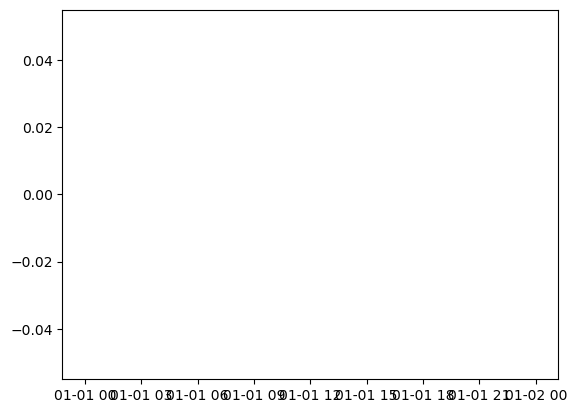

In [169]:
sns.lineplot(data=hist_weather, x="datetime", y=81)

0
1
2
3
4
5
6


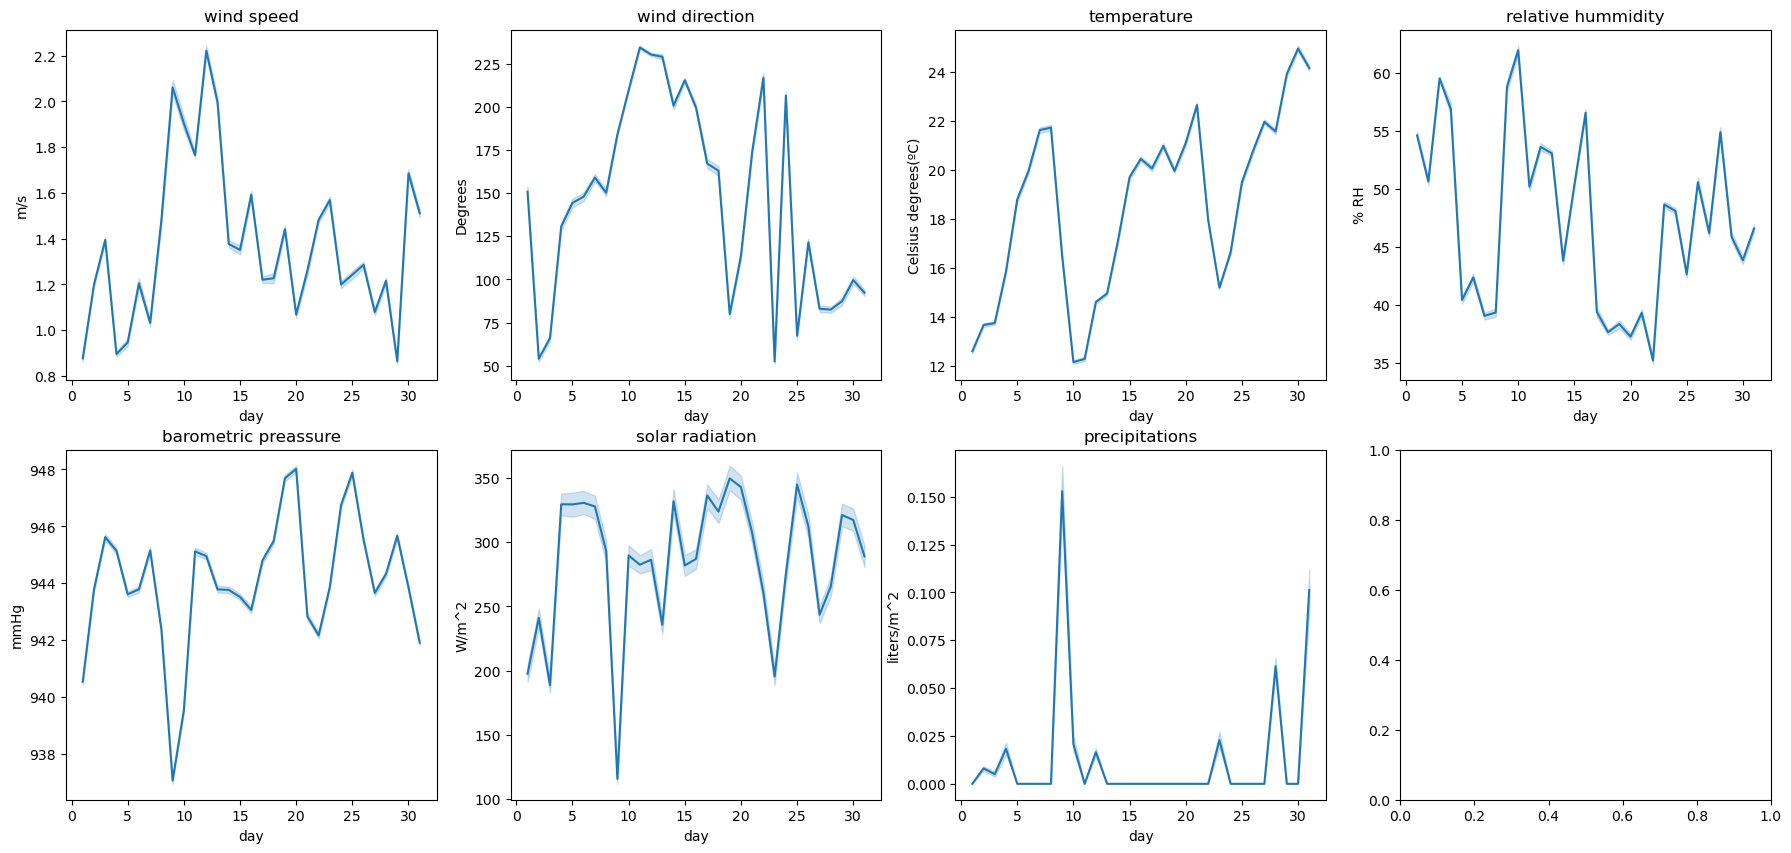

In [171]:
nrows = 2
ncols = 4

magnitude_dict = {
    81: {"name": "wind speed",
         "units": "m/s"},
    82: {"name": "wind direction",
         "units": "Degrees"},
    83: {"name": "temperature",
         "units": "Celsius degrees(ºC)"},
    86: {"name": "relative hummidity",
         "units": "% RH"},
    87: {"name": "barometric preassure",
         "units": "mmHg"},
    88: {"name": "solar radiation",
         "units": "W/m^2"},
    89: {"name": "precipitations",
         "units": "liters/m^2"},
}


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 10))


for index, magnitude in enumerate(MAGNITUDES):
    # this is to build the rows and columns of the subplot
    print(index)
    if index < ncols:
        row = 0
        col = index
    else:
        row = 1
        col = index - ncols

    sns.lineplot(data=hist_stations_weather_may, x="day", y=magnitude, ax=axes[row, col])
    
    
    # setting titles and units to the subplots
    axes[row,col].set(title=magnitude_dict.get(magnitude).get("name"), ylabel=magnitude_dict.get(magnitude).get("units"))

### Saving file

In [ ]:
#hist_stations_weather.to_csv(os.path.join(data_folder, "historical_data/202105_merged_weather_trips_stations.csv"), index=False)